In [1]:
# generative model
from src.SlovotvirModelM import run_model_parallel

# bayesflow components
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import (InvertibleNetwork, 
                                DeepSet)
from bayesflow.trainers import (Trainer, 
                                SimulationDataset)
import tensorflow as tf

# other
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
import seaborn as sns
import arviz as az
from tabulate import tabulate
from sklearn.decomposition import PCA

# helpher functions
from src.helpers import (generate_latex_table,
                         configure_input,
                         binning,
                         plot_posterior,
                         train_and_amortize)

/opt/homebrew/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
RNG = np.random.default_rng(2023)

In [8]:
fake_dist = run_model_parallel([10], [1], [1.3], 1)
fake_dist_bins = binning(fake_dist[0])

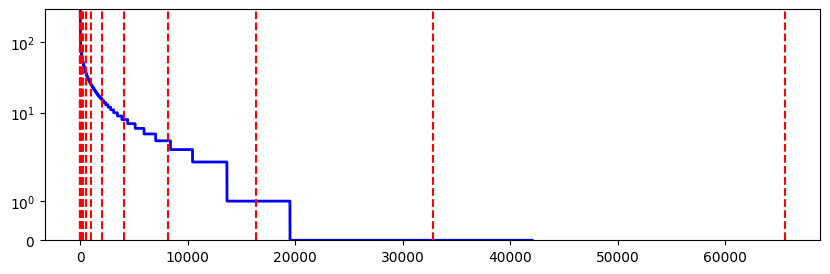

In [9]:
# plot fake dist
plt.figure(figsize=(10, 3))
plt.plot(fake_dist[0], color='blue', linewidth=2)
plt.grid(False)
# add vertical lines at powers of 2
for i in range(1, 17):
    plt.axvline(2 ** i, color="red", linestyle="--", alpha=1)
    # add text from fake_dist_bins turn 90 degrees
    # plt.text(2 ** i - 1, 10^4, str(fake_dist_bins[i-1]), rotation=90)
# plt.xscale("log")
plt.yscale("symlog", base=10)
plt.ylim(0, None)
# plt.xscale("log")
plt.show()

## Inference of all 3 parameters

In [10]:
train_size = 1000
test_size = 10
valid_size = 10

### 1. Generating training and testing data

In [ ]:
# training_params = (np.random.uniform(0, 10, train_size), np.random.uniform(0, 10, train_size), np.random.lognormal(0, 0.5, train_size))
# testing_params = (np.random.uniform(0, 10, test_size), np.random.uniform(0, 10, test_size), np.random.lognormal(0, 0.5, test_size))
# validation_params = (np.random.uniform(0, 10, valid_size), np.random.uniform(0, 10, valid_size), np.random.lognormal(0, 0.5, valid_size))

In [ ]:
# training_data = run_model_parallel(training_params[0], training_params[1], training_params[2], train_size)

In [ ]:
# testing_data = run_model_parallel(testing_params[0], testing_params[1], testing_params[2], test_size)

In [ ]:
# validation_data = run_model_parallel(validation_params[0], validation_params[1], validation_params[2], valid_size)

In [ ]:
# training_params = np.vstack(training_params)
# testing_params = np.vstack(testing_params)
# validation_params = np.vstack(validation_params)

In [ ]:
# train_data = {}
# train_data["prior_non_batchable_context"] = None
# train_data["prior_batchable_context"] = None
# train_data["prior_draws"] = training_params.reshape(num_params, train_size).T
# train_data["sim_non_batchable_context"] = None
# train_data["sim_batchable_context"] = None
# train_data["sim_data"] = np.array(training_data, dtype = float)


# test_data = {}
# test_data["prior_non_batchable_context"] = None
# test_data["prior_batchable_context"] = None
# test_data["prior_draws"] = testing_params.reshape(num_params, test_size).T
# test_data["sim_non_batchable_context"] = None
# test_data["sim_batchable_context"] = None
# test_data["sim_data"] = np.array(testing_data, dtype = float)

# valid_data = {}
# valid_data["prior_non_batchable_context"] = None
# valid_data["prior_batchable_context"] = None
# valid_data["prior_draws"] = validation_params.reshape(num_params, valid_size).T
# valid_data["sim_non_batchable_context"] = None
# valid_data["sim_batchable_context"] = None
# valid_data["sim_data"] = np.array(validation_data, dtype = float)

In [11]:
# pickle.dump(train_data, open("data/train_data_1405.pkl", "wb"))
# pickle.dump(test_data, open("data/test_data_1405.pkl", "wb"))
# pickle.dump(valid_data, open("data/valid_data_1405.pkl", "wb"))
# load data
train_data = pickle.load(open("data/train_data_1405.pkl", "rb"))
test_data = pickle.load(open("data/test_data_1405.pkl", "rb"))
valid_data = pickle.load(open("data/valid_data_1405.pkl", "rb"))

In [13]:
# train_data_ = pickle.load(open("data/train_data_1205.pkl", "rb"))
# test_data_ = pickle.load(open("data/test_data_1205.pkl", "rb"))
# valid_data_ = pickle.load(open("data/valid_data_1205.pkl", "rb"))

In [14]:
# # train_data["sim_data"].shape
# train_data_["sim_data"] = np.array(list(map(binning, train_data_["sim_data"])))
# test_data_["sim_data"] = np.array(list(map(binning, test_data_["sim_data"])))
# valid_data_["sim_data"] = np.array(list(map(binning, valid_data_["sim_data"])))

In [15]:
# # combine sim_data and prior_draws
# train_data["sim_data"] = np.concatenate((train_data["sim_data"], train_data_["sim_data"]))
# train_data["prior_draws"] = np.concatenate((train_data["prior_draws"], train_data_["prior_draws"]))
# test_data["sim_data"] = np.concatenate((test_data["sim_data"], test_data_["sim_data"]))
# test_data["prior_draws"] = np.concatenate((test_data["prior_draws"], test_data_["prior_draws"]))
# valid_data["sim_data"] = np.concatenate((valid_data["sim_data"], valid_data_["sim_data"]))
# valid_data["prior_draws"] = np.concatenate((valid_data["prior_draws"], valid_data_["prior_draws"]))

In [29]:
# # apply binning to each entry in sim_data using map
# train_data["sim_data"] = np.array(list(map(binning, train_data["sim_data"])))
# test_data["sim_data"] = np.array(list(map(binning, test_data["sim_data"])))
# valid_data["sim_data"] = np.array(list(map(binning, valid_data["sim_data"])))

In [12]:
prior_means = np.mean(train_data["prior_draws"], axis=0)
prior_stds = np.std(train_data["prior_draws"], axis=0)

In [13]:
train_data['sim_data'].shape

(80000, 17)

### 2. Training the model

In [14]:
num_params = 3
epochs = 10
batch_size = 32
learning_rate = 0.001

In [15]:
history, trainer, amortizer = train_and_amortize(train_data, batch_size, test_data, epochs, 
                                                 num_params, 4, learning_rate, prior_means, prior_stds)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


Training epoch 1:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 1.355


Training epoch 2:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 1.458


Training epoch 3:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 0.893


Training epoch 4:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 0.649


Training epoch 5:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 0.541


Training epoch 6:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 0.383


Training epoch 7:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 0.213


Training epoch 8:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 0.098


Training epoch 9:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: -0.006


Training epoch 10:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: -0.042


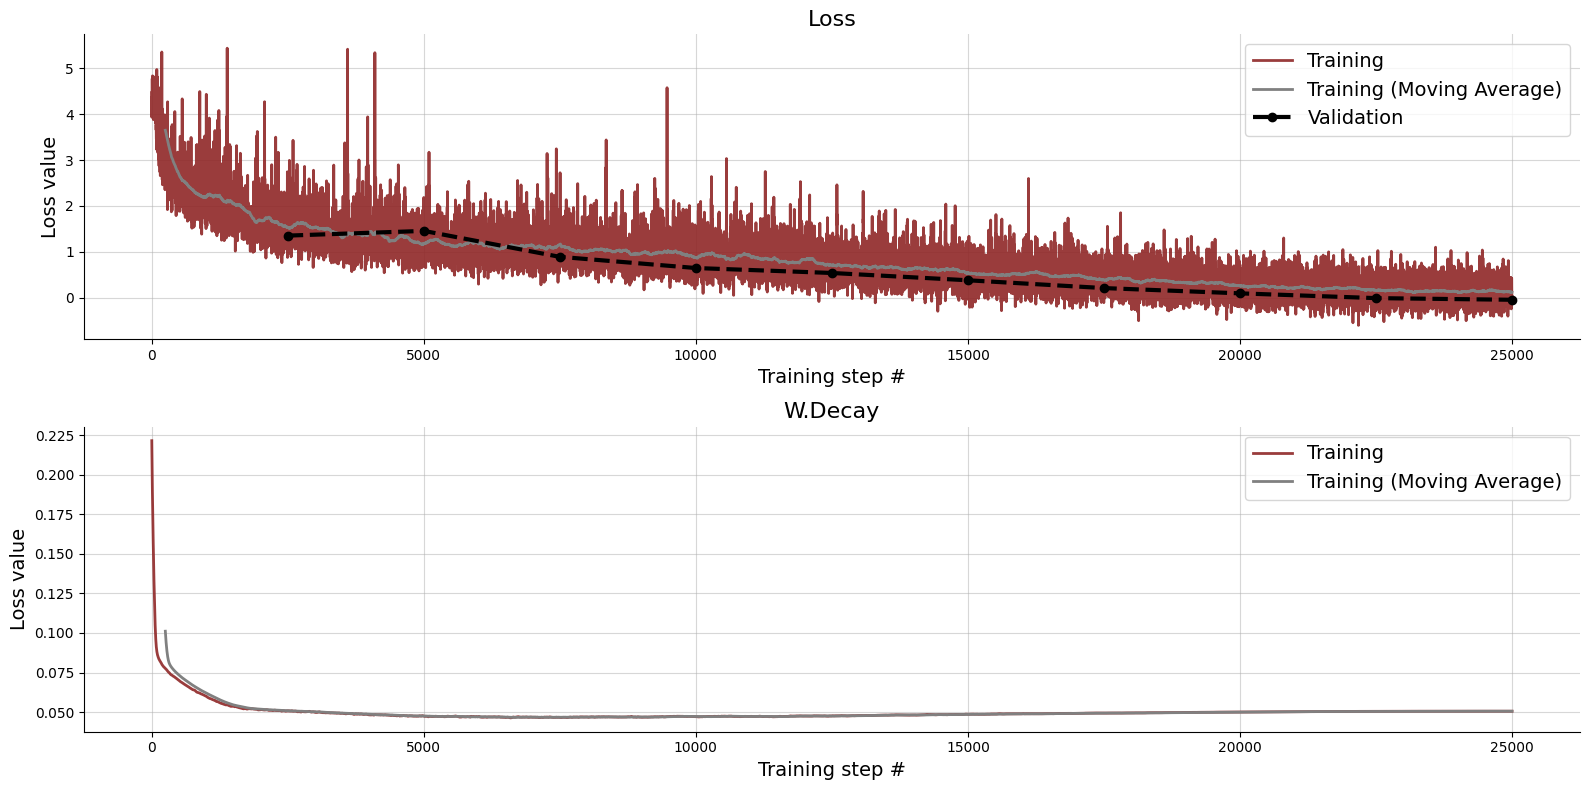

In [16]:
f = diag.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

### 3. Model analysis

In [22]:
# Generate some validation data
validation_sims = trainer.configurator(valid_data) 
prior_samples = validation_sims["parameters"] * prior_stds + prior_means
# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)
post_samples = post_samples * prior_stds + prior_means

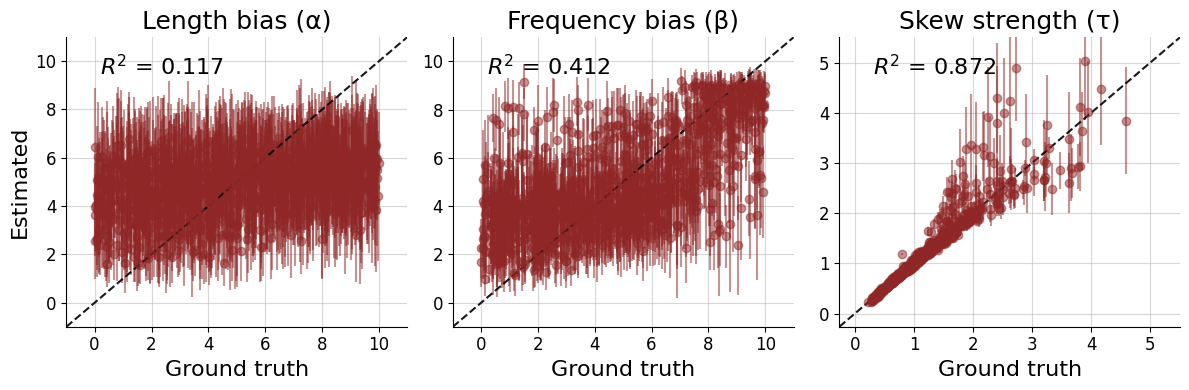

In [23]:
fig = diag.plot_recovery(post_samples[0:1000], prior_samples[0:1000], add_corr=False,
                         param_names=['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'],
                         )
# point_agg=np.mean, uncertainty_agg=np.std

In [24]:
post_samples.shape

(8000, 100, 3)

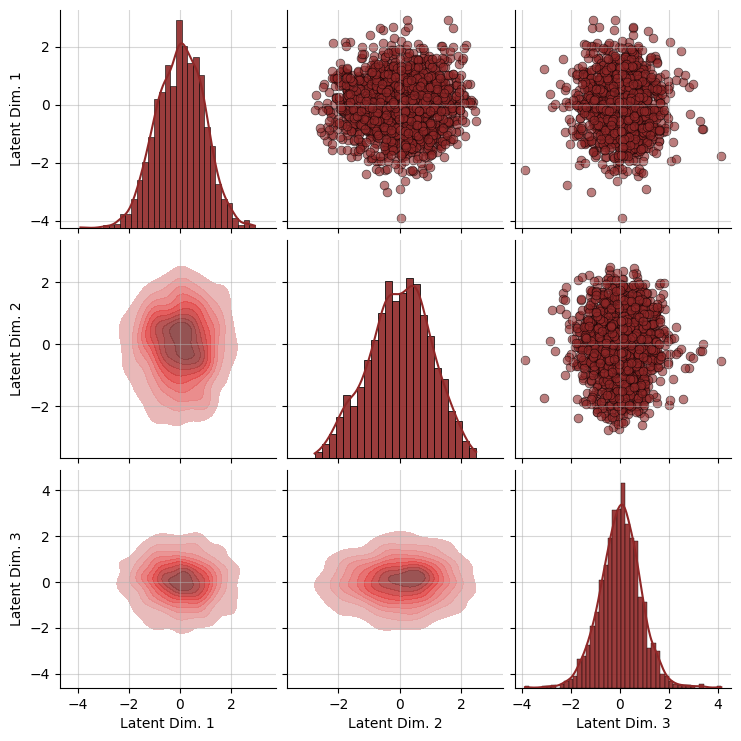

In [25]:
f = trainer.diagnose_latent2d()

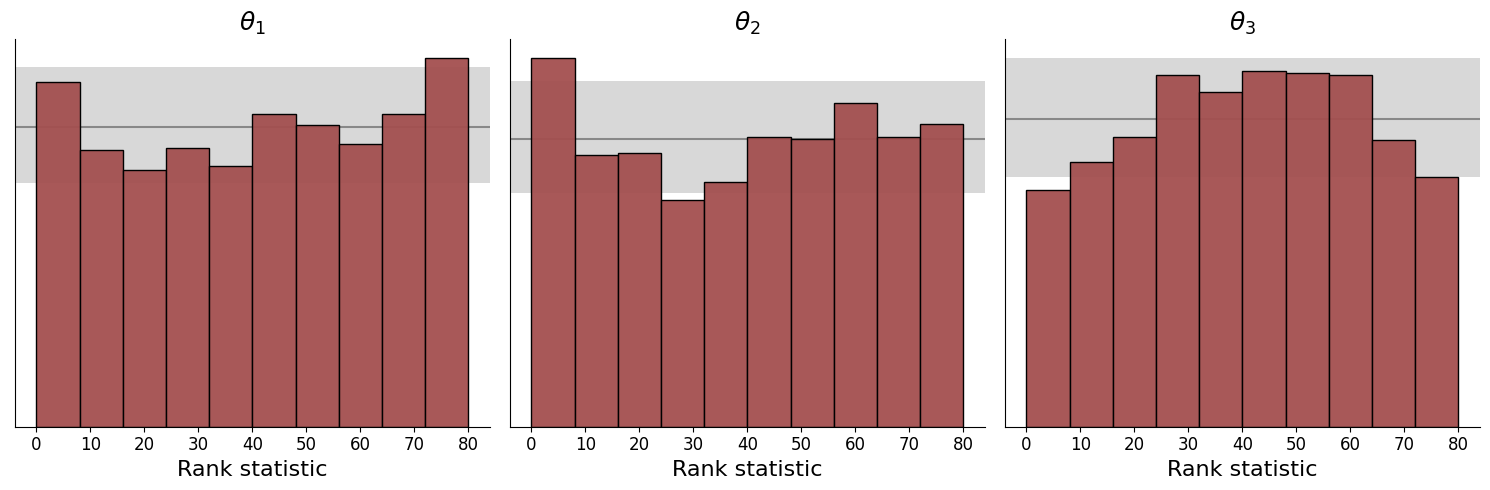

In [26]:
f = trainer.diagnose_sbc_histograms()

### 4. Posterior analysis

In [35]:
a = 5
b = 1
tau = 1

In [36]:
fake_dist = run_model_parallel([a], [b], [tau], 1)
# apply binning to each entry in sim_data using map
fake_dist = np.array(list(map(binning, fake_dist)))

In [37]:
obs_data = np.log1p(fake_dist[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [38]:
# Obtain 500 posterior draws given real data
post_samples_ = amortizer.sample({"summary_conditions": obs_data}, 10000)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples_ = prior_means + post_samples_ * prior_stds

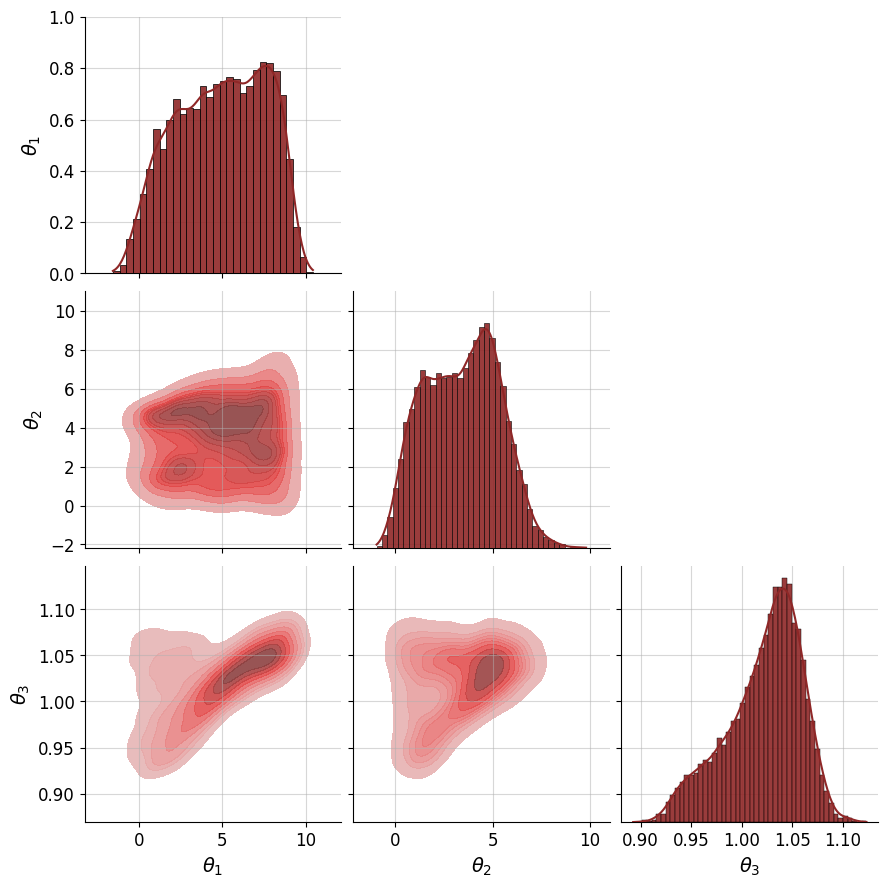

In [39]:
f = diag.plot_posterior_2d(post_samples_)

In [40]:
print(generate_latex_table(['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'], post_samples_))

\begin{tabular}{lrl}
\hline
 Parameter          &   Mean & HDI             \\
\hline
 Length bias (α)    &  4.913 & [0.282 9.232]   \\
 Frequency bias (β) &  3.416 & [-0.012  6.623] \\
 Skew strength (τ)  &  1.022 & [0.94 1.08]     \\
\hline
\end{tabular}


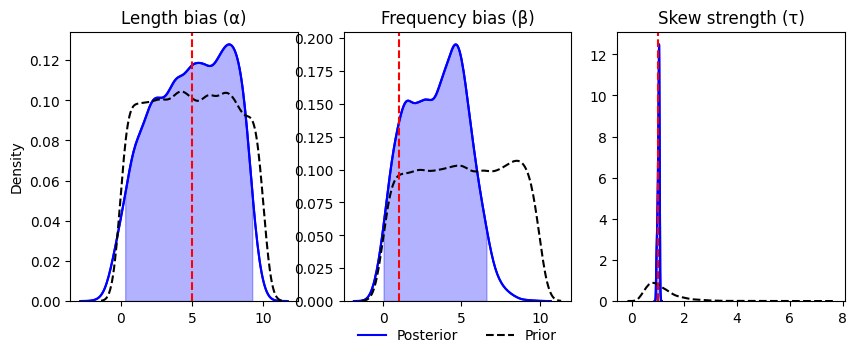

In [41]:
plot_posterior(post_samples_, ['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'], [a, b, tau], save=None)

In [42]:
# Perform PCA
pca = PCA(n_components=2, whiten=True)
pca_result = pca.fit_transform(train_data['sim_data'])

true_hist = obs_data.reshape(1, -1)
pca_true = pca.transform(true_hist)

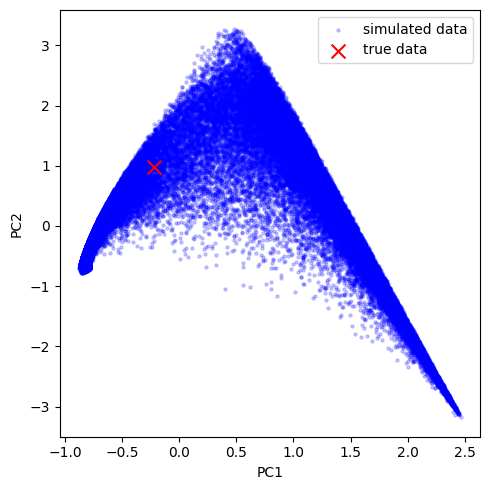

In [43]:
# Plot PCA
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            s=5, color = 'blue', 
            alpha=0.2, label='simulated data')
plt.scatter(pca_true[:, 0], pca_true[:, 1],
             s=100, color='red', marker='x', 
             label='true data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.savefig('figures/pca.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Inference of alpha and beta knowing tau

### 1. Data generation

In [146]:
train_size = 1000
test_size = 10
valid_size = 10

num_params = 2

In [147]:
np.mean(post_samples_[:, 2])

1.842400345652659

In [148]:
training_params_2 = (np.random.uniform(0, 10, train_size), 
                   np.random.uniform(0, 10, train_size), 
                  [np.mean(post_samples_[:, 2])] * train_size)
testing_params_2 = (np.random.uniform(0, 10, test_size), 
                  np.random.uniform(0, 10, test_size), 
                 [np.mean(post_samples_[:, 2])] * test_size)
validation_params_2 = (np.random.uniform(0, 10, valid_size), 
                     np.random.uniform(0, 10, valid_size),
                    [np.mean(post_samples_[:, 2])] * valid_size)

In [149]:
training_data_2 = run_model_parallel(training_params_2[0], training_params_2[1], training_params_2[2], train_size)

In [150]:
testing_data_2 = run_model_parallel(testing_params_2[0], testing_params_2[1], testing_params_2[2], test_size)

In [151]:
validation_data_2 = run_model_parallel(validation_params_2[0], validation_params_2[1], validation_params_2[2], valid_size)

In [152]:
training_params_2 = np.vstack(training_params_2)
testing_params_2 = np.vstack(testing_params_2)
validation_params_2 = np.vstack(validation_params_2)

In [153]:
# remove last array from params
training_params_2 = training_params_2[:-1]
testing_params_2 = testing_params_2[:-1]
validation_params_2 = validation_params_2[:-1]

In [154]:
train_data_2 = {}
train_data_2["prior_non_batchable_context"] = None
train_data_2["prior_batchable_context"] = None
train_data_2["prior_draws"] = training_params_2.reshape(num_params, train_size).T
train_data_2["sim_non_batchable_context"] = None
train_data_2["sim_batchable_context"] = None
train_data_2["sim_data"] = np.array(training_data_2, dtype = float)


test_data_2 = {}
test_data_2["prior_non_batchable_context"] = None
test_data_2["prior_batchable_context"] = None
test_data_2["prior_draws"] = testing_params_2.reshape(num_params, test_size).T
test_data_2["sim_non_batchable_context"] = None
test_data_2["sim_batchable_context"] = None
test_data_2["sim_data"] = np.array(testing_data_2, dtype = float)

valid_data_2 = {}
valid_data_2["prior_non_batchable_context"] = None
valid_data_2["prior_batchable_context"] = None
valid_data_2["prior_draws"] = validation_params_2.reshape(num_params, valid_size).T
valid_data_2["sim_non_batchable_context"] = None
valid_data_2["sim_batchable_context"] = None
valid_data_2["sim_data"] = np.array(validation_data_2, dtype = float)

In [155]:
# train_data["sim_data"].shape
train_data_2["sim_data"] = np.array(list(map(binning, train_data_2["sim_data"])))
test_data_2["sim_data"] = np.array(list(map(binning, test_data_2["sim_data"])))
valid_data_2["sim_data"] = np.array(list(map(binning, valid_data_2["sim_data"])))

In [156]:
prior_means_2 = np.mean(train_data_2["prior_draws"], axis=0)
prior_stds_2 = np.std(train_data_2["prior_draws"], axis=0)

### 2. Model training

In [157]:
num_params = 2
epochs = 10
batch_size = 32
learning_rate = 0.001

history_2, trainer_2, amortizer_2 = train_and_amortize(train_data_2, batch_size, test_data_2, 
                                                       epochs, num_params, 4, learning_rate, prior_means_2, prior_stds_2)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


Training epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 3.287


Training epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 3.269


Training epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 3.269


Training epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 3.268


Training epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 3.272


Training epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 3.273


Training epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 3.262
INFO:root:Early stopping triggered.


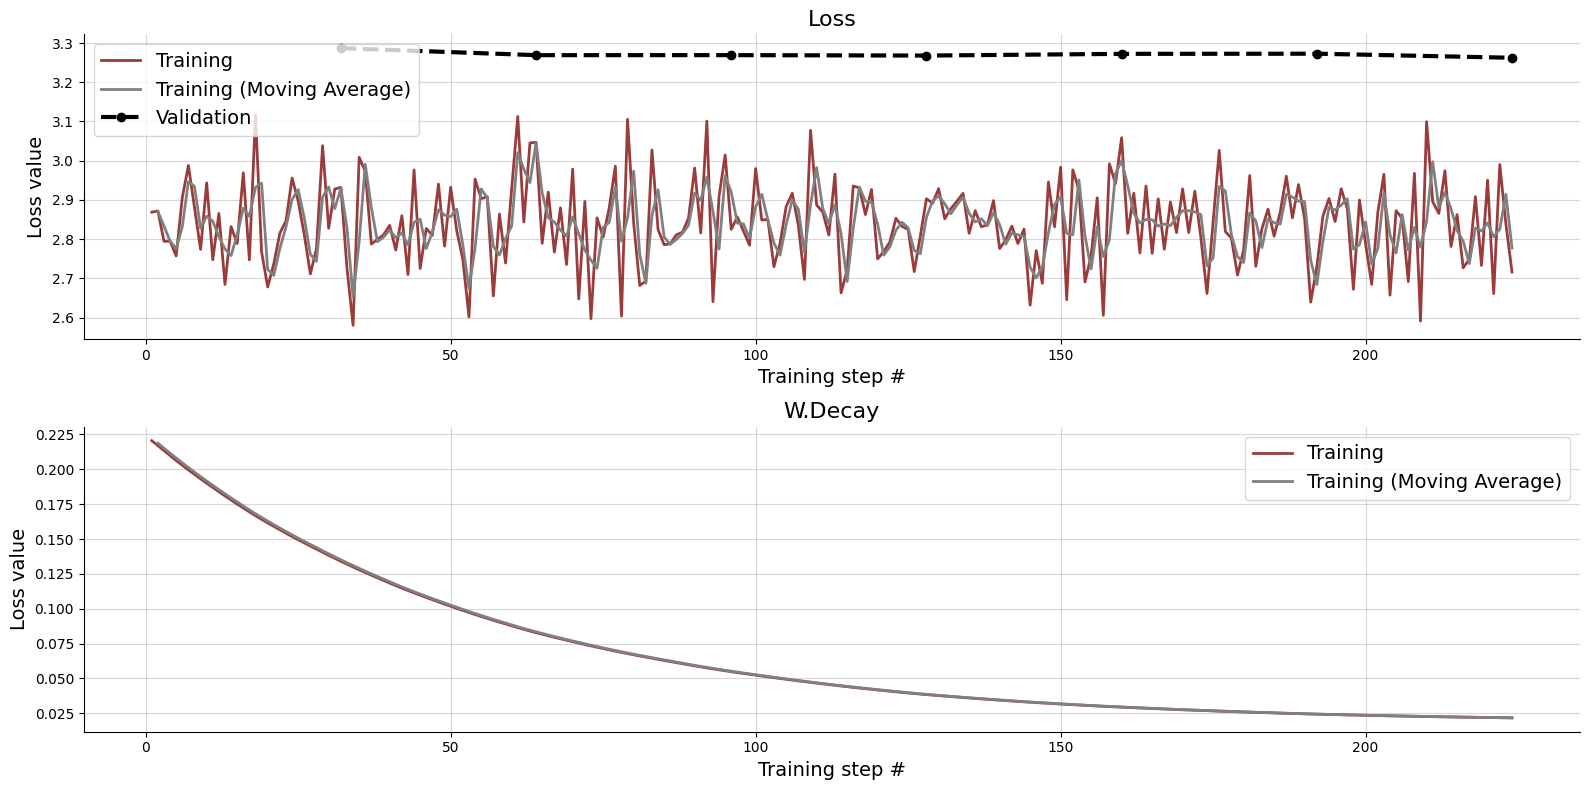

In [161]:
f = diag.plot_losses(history_2["train_losses"], history_2["val_losses"], moving_average=True)

In [164]:
# Generate some validation data
validation_sims = trainer_2.configurator(valid_data_2) 
prior_samples = validation_sims["parameters"] * prior_stds_2 + prior_means_2
# Generate posterior draws for all simulations
post_samples = amortizer_2.sample(validation_sims, n_samples=100)
post_samples = post_samples * prior_stds_2 + prior_means_2

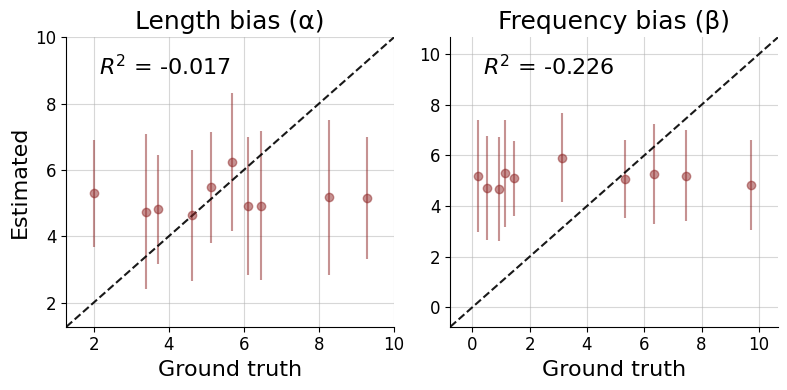

In [165]:
fig = diag.plot_recovery(post_samples[0:1000], prior_samples[0:1000], add_corr=False,
                         param_names=['Length bias (α)', 'Frequency bias (β)'],
                         )
# point_agg=np.mean, uncertainty_agg=np.std

### 4. Posterior analysis

In [166]:
a = 1
b = 10
tau = np.mean(post_samples_[:, 2])

In [167]:
fake_dist = run_model_parallel([a], [b], [tau], 1)
fake_dist = np.array(list(map(binning, fake_dist)))

In [168]:
obs_data = np.log1p(fake_dist[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [170]:
# Obtain 500 posterior draws given real data
post_samples_ = amortizer_2.sample({"summary_conditions": obs_data}, 10000)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples_ = prior_means_2 + post_samples_ * prior_stds_2

In [193]:
print(generate_latex_table(['Length bias (α)', 'Frequency bias (β)'], post_samples_))

\begin{tabular}{lrl}
\hline
 Parameter          &   Mean & HDI             \\
\hline
 Length bias (α)    &  6.307 & [ 0.796 10.637] \\
 Frequency bias (β) &  5.286 & [0.9   9.218]   \\
\hline
\end{tabular}
